<a href="https://colab.research.google.com/github/xAn-x/Language-Modelling-Zero-to-One/blob/master/01_Bigram_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Understanding the Bigram Model

A Bigram Model is a simple way to predict the next word in a sequence by looking at the previous word. It's called "bigram" because it considers pairs of words (bi means two). Here's a step-by-step explanation:

1. **Data Preparation**:
   - Collect a large amount of text.
   - Split the text into individual words.

2. **Counting Pairs**:
   - Count how often each word pair appears. For example, in the sentence "I love coding," the pairs are "I love" and "love coding."

3. **Probability Calculation**:
   - Calculate the probability of a word following another word. For example, if "love" appears 10 times after "I" and "I" appears 20 times overall, the probability is 10/20 or 0.5.

4. **Prediction**:
   - To predict the next word, look at the current word and choose the word with the highest probability of following it. For example, if "I" is the current word, and "love" has the highest probability of following "I," then "love" is the predicted next word.

### Example

Let's say we have this simple text:

"I love coding. I love machine learning. I enjoy learning new things."

1. **Pairs**:
   - "I love" appears twice.
   - "love coding" appears once.
   - "coding I" appears once (if we treat sentences as continuous).
   - "I enjoy" appears once.
   - "enjoy learning" appears once.
   - "learning new" appears once.
   - "new things" appears once.

2. **Probability Calculation**:
   - P(love | I) = 2/3 (since "I" appears three times in total: twice followed by "love" and once by "enjoy").
   - P(coding | love) = 1/2 (since "love" appears twice: once followed by "coding" and once by "machine").
   - P(machine | love) = 1/2.

3. **Prediction**:
   - If the current word is "I," the model predicts "love" because it has the highest probability (2/3).
   - If the current word is "love," the model predicts "coding" or "machine" with equal probability (1/2 each).

The Bigram Model is simple and easy to understand but has limitations. It only considers one previous word, so it doesn't capture long-range dependencies or context. More advanced models like Trigrams (considering two previous words) or Transformers address these limitations by considering a broader context.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [3]:
! wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-07-07 13:28:48--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-07-07 13:28:48 (17.2 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [4]:
with open('input.txt','r',encoding='utf-8') as f:
    text = f.read()

In [6]:
print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [7]:
vocab=sorted(list(set(text)))

vocab_size=len(vocab)
print(f"vocab size: {vocab_size}")
print(f"vocab: {vocab}")

vocab size: 65
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
stoi={ch:i for i,ch in enumerate(vocab)}
itos={i:ch for i,ch in enumerate(vocab)}

def encode(s:str)->list:
    return [stoi[ch] for ch in s]

def decode(l:list)->str:
    return ''.join([itos[i] for i in l])

In [9]:
print(encode("Hello,World"))
print(decode(encode("Hello,World")))

[20, 43, 50, 50, 53, 6, 35, 53, 56, 50, 42]
Hello,World


In [12]:
data=torch.tensor(encode(text),dtype=torch.long)

matrix=torch.zeros([vocab_size,vocab_size],dtype=torch.long)
for ch1,ch2 in zip(data,data[1:]):
    matrix[ch1,ch2]+=1

In [13]:
matrix.shape

torch.Size([65, 65])

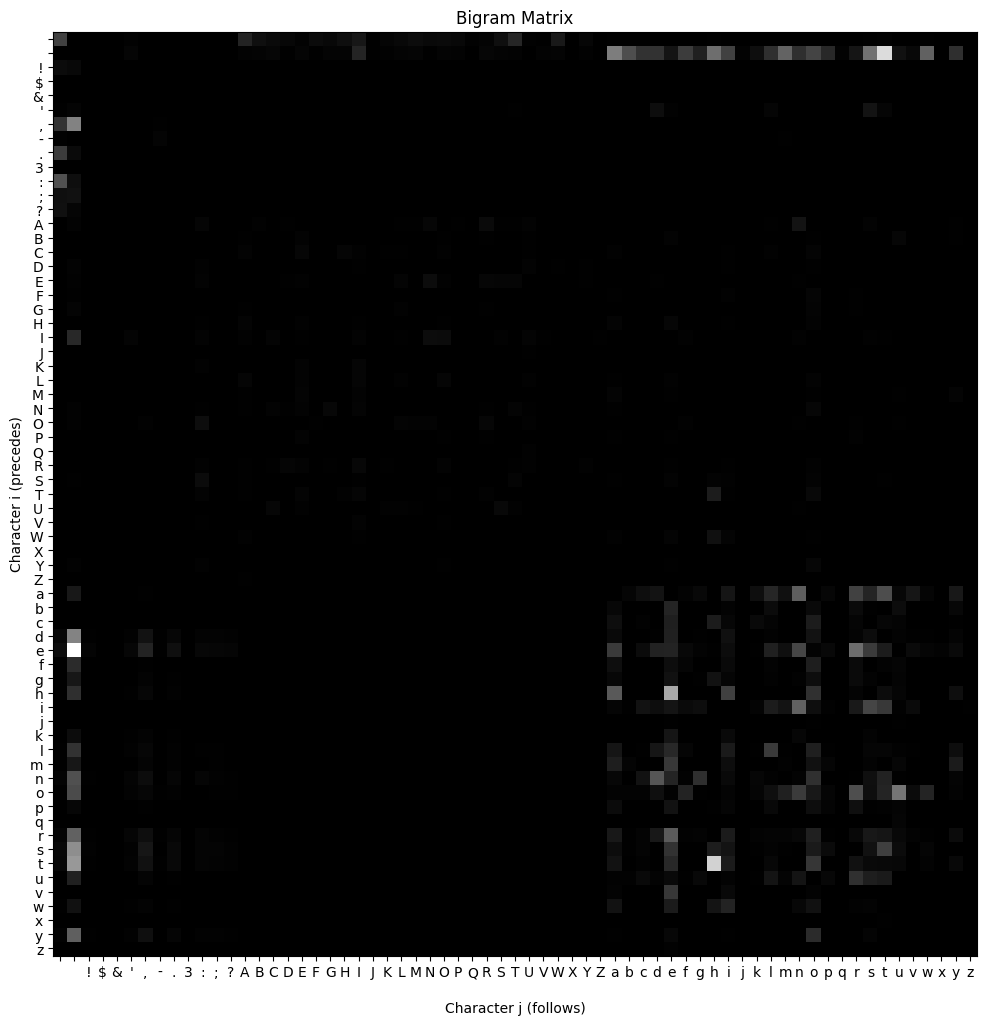

In [23]:
# Plotting the bigram matrix
plt.figure(figsize=(12, 12))
plt.imshow(matrix, cmap='gray', interpolation='nearest')
# plt.colorbar()
plt.title("Bigram Matrix")
plt.xlabel("Character j (follows)")
plt.ylabel("Character i (precedes)")
plt.xticks(ticks=np.arange(len(vocab)), labels=[itos[i] for i in range(len(vocab))])
plt.yticks(ticks=np.arange(len(vocab)), labels=[itos[i] for i in range(len(vocab))])
plt.show()

`We can see There are some region more pronounced than others => our model has learned something`

In [27]:
probs=matrix/torch.sum(matrix,dim=-1,keepdim=True) # Normalize the rows

In [29]:
def generate_text(n_chars=500):
  idx=0 # '/n' char start with this and keep generating
  chars=[]
  for i in range(n_chars):
    row=probs[idx]
    idx=torch.multinomial(row,num_samples=1).item()
    chars.append(itos[idx])
  return ''.join(chars)

In [32]:
print(generate_text(700))

TIS:
Thiee unabe gr ico mant mithee mes hamad we thy henksigis; ber mu yovigng d be ishom, oupo rarotiverewio ces gseareranohes wsplllfim an parora grond Teer'el caveaccaputouslorounomberde t Virend cad, s yo'r, Rin;

YOMI prs meror omaisurs ay y uswod s fo y, th atil t,


Youter y hororalindin ig'be, od,

N mang be ut f yond, mo; rour witheamig,
HO:
SBule t hent toncara
THIDomer 'sfeu:

ABEENRToout ndiot as---d o IUMy INarom'ssind mabeild s sor:
Gaithan thaily anothind the hr,
ARSOR: fa ye d tcesirin he ord, nd, d nde, ts CI le,
Br us memy.
CIORWe mabjoran!
KENomiosshosithe t Bu to qusthil.
BENClllinds

Helice!-Orithand latheaimatheshindsth wimyous le ndell alecas oforss f towi'd youstheeli
